In [135]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (14.0, 5.0)

In [136]:
np.random.seed(7)

In [137]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [138]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [139]:
class ModelBoi(Model):
  def __init__(self):
    super(ModelBoi, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10)

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

model=ModelBoi()

In [140]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [141]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [142]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_acc(labels, predictions)

In [143]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_acc(labels, predictions)

In [144]:
EPOCHS = 10

In [145]:
train_loss_results = []
train_accuracy_results = []
test_loss_results = []
test_accuracy_results = []

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_acc.reset_states()
  test_loss.reset_states()
  train_acc.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        test_loss.result(),
                        test_acc.result() * 100))
  train_loss_results.append(train_loss.result())
  train_accuracy_results.append(train_acc.result() * 100)
  test_loss_results.append(test_loss.result())
  test_accuracy_results.append(test_acc.result() * 100)

RuntimeError: __iter__() is only supported inside of tf.function or when eager execution is enabled.

ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

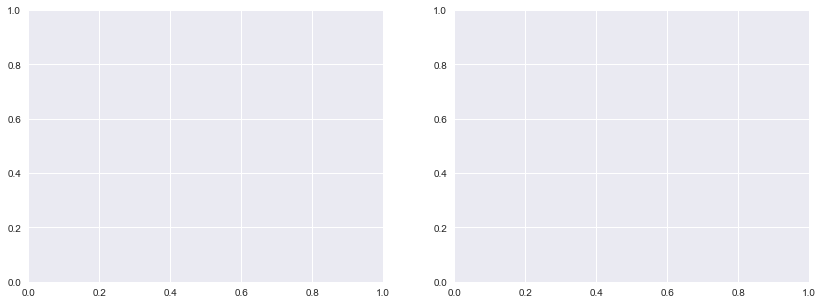

In [146]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot([x for x in range(1,EPOCHS+1)], train_loss_results, label='training loss', marker='^')
ax1.plot([x for x in range(1,EPOCHS+1)], test_loss_results, label='testing loss', marker='^')
ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax2.plot([x for x in range(1,EPOCHS+1)], train_accuracy_results, label='training accuracy', marker='o')
ax2.plot([x for x in range(1,EPOCHS+1)], test_accuracy_results, label='testing accuracy', marker='o')
ax2.set_title("Accuracy")
ax2.set_xlabel("Epoch")
ax1.legend(loc=7)
ax2.legend(loc=6)
fig.tight_layout()